In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df_1 = pd.read_csv('Practice/6/1.txt', header=None)
df_2 = pd.read_csv('Practice/6/2.txt', header=None)

In [2]:
df_1[1] = np.arange(1, 65)
df_2[1] = np.arange(1, 65)

In [3]:
df_1.columns = [['Y', 't']]
df_2.columns = [['Y', 't']]

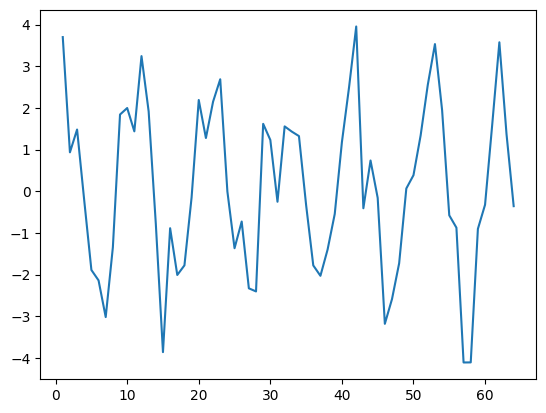

In [4]:
plt.plot(df_1['t'], df_1['Y'])

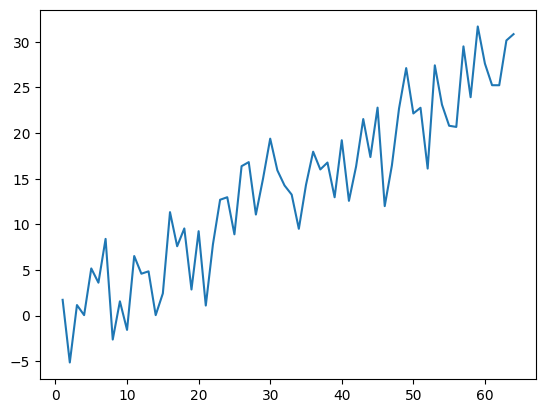

In [5]:
plt.plot(df_2['t'], df_2['Y'])

In [6]:
time_s_1 = np.array(df_1['Y']).flatten()
time_s_2 = np.array(df_2['Y']).flatten()

# SMA

In [7]:
def sma(df, m):
  w = 1/(2*m+1)
  len_ = len(df)
  for i in range(m):
    df = np.insert(df, 0, df[0])
    df = np.append(df, df[-1])
  y_new=[]
  itog = []
  for i in range(len(df)):
    if i == len_:
      break
    for j in range(i, i+2*m+1):
      y_new.append(df[j]*w)
    itog.append(sum(y_new))
    y_new.clear()
  return itog

In [8]:
def autocorr(k, df):
  n = len(df)
  xt_numerator = []
  for i in range(n-k):
    xt_numerator.append(df[i] * df[i+k])
  sum_1 = np.sum(xt_numerator)
  numerator_1=(n-k)*sum_1
  xt_numerator_1 = []
  xt_numerator_2 = []
  for i in range(n-k):
    xt_numerator_1.append(df[i])
    xt_numerator_2.append(df[i+k])
  numerator_2 = np.sum(xt_numerator_1)*np.sum(xt_numerator_2)
  numerator = numerator_1 - numerator_2
  xt_denominator = []
  for i in range(n-k):
    xt_denominator.append(df[i]**2)
  #print('n-k', n-k)
  #print('xt_denominator', (n-k)*np.sum(xt_denominator))
  #print('xt_numerator_1', ((np.sum(xt_numerator_1))**2))
  denominator_1 = np.sqrt(((n-k)*np.sum(xt_denominator)) - ((np.sum(xt_numerator_1))**2))
  xt_denominator_1 = []
  for i in range(n-k):
    xt_denominator_1.append(df[i+k]**2)
  denominator_2 = np.sqrt(((n-k)*np.sum(xt_denominator_1)) - ((np.sum(xt_numerator_2))**2))
  denominator = denominator_1 * denominator_2
  return numerator/denominator

In [9]:
from scipy.stats import chi2
def Q(m, df):
  n = len(df)
  autocor = []
  for i in range(1, m+1):
    autocor.append(((autocorr(i, df))**2)/(n-i))
  Q_stat = n*(n+2)*np.sum(autocor)
  if Q_stat > chi2.ppf(0.95, m):
    return f'Автокорреляция присутствует: {Q_stat}>{chi2.ppf(0.95, m)}'
  else:
    return f'Автокорреляция отсутствует: {Q_stat}<{chi2.ppf(0.95, m)}'

In [10]:
from scipy.stats import chi2
def Q_chet(m, df):
  n = len(df)
  autocor = []
  for i in range(1, m+1):
    autocor.append(((autocorr(i, df))**2)/(n-i))
  Q_stat = n*(n+2)*np.sum(autocor)
  return Q_stat

In [11]:
ms_1 = []
ms_2 = []
for m in range(1, 50):
  itog_1 = np.array(sma(time_s_1, m))
  itog_2 = np.array(sma(time_s_2, m))
  #print(sm.stats.acorr_ljungbox(df_1['Y'].values.flatten() - itog_1, lags=[5], return_df=False).lb_stat.values[0])
  #print(Q_chet(5, df_1['Y'].values.flatten() - itog_1))
  ms_1.append(Q_chet(5, df_1['Y'].values.flatten() - itog_1))
  ms_2.append(Q_chet(5, df_2['Y'].values.flatten() - itog_2))

In [12]:
sm.stats.acorr_ljungbox(np.array(df_1['Y'].values - np.array(sma(time_s_1, 1))).flatten(), lags=[5], return_df=False).lb_stat.values[0]

7392.688450559968

In [13]:
print("Параметр для первого ряда, при котором Q-статистика минимальна =", np.argmin(ms_1) + 1)
print("Параметр для второго ряда, при котором Q-статистика минимальна =", np.argmin(ms_2) + 1)

Параметр для первого ряда, при котором Q-статистика минимальна = 1
Параметр для второго ряда, при котором Q-статистика минимальна = 19


In [14]:
itog_1 = np.array(sma(time_s_1, np.argmin(ms_1) + 1)).reshape(64, 1)
itog_2 = np.array(sma(time_s_2, np.argmin(ms_2) + 1)).reshape(64, 1)

In [15]:
df_1['e'] = df_1['Y'].values - itog_1
df_2['e'] = df_2['Y'].values - itog_2

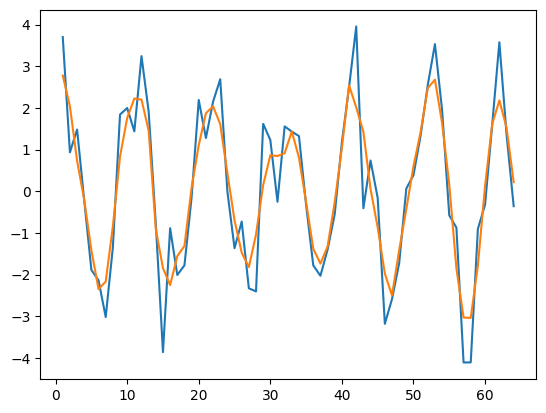

In [16]:
plt.plot(df_1['t'], df_1['Y'])
plt.plot(df_1['t'], itog_1)

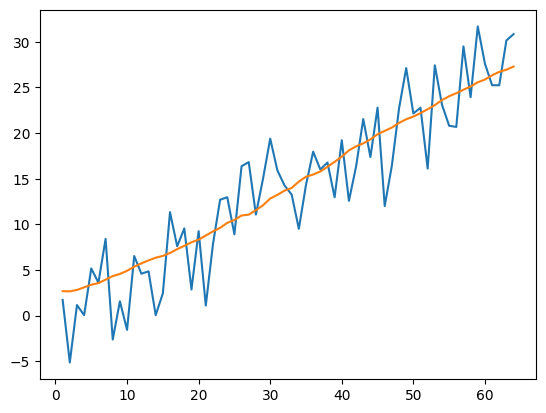

In [17]:
plt.plot(df_2['t'], df_2['Y'])
plt.plot(df_2['t'], itog_2)

In [18]:
print("Для первого ряда", Q(5, np.array(df_1['e'])))
print("Для второго ряда",Q(5, np.array(df_2['e'])))

Для первого ряда Автокорреляция присутствует: 29.348837005471434>11.070497693516351
Для второго ряда Автокорреляция отсутствует: 4.227033257376399<11.070497693516351


In [19]:
def darbin_watson(df):
  res_num = []
  for i in range(1, len(df)-1):
    res_num.append((df[i] - df[i-1])**2)
  numerator = np.sum(res_num)
  res_denum = []
  for i in range(len(df)):
    res_denum.append((df[i])**2)
  denumerator = np.sum(res_denum)
  return numerator/denumerator

In [20]:
dl = 1.536
du = 1.662
if 0 <= darbin_watson(np.array(df_1['e'])) <= 2:
  print('Для первого файла -','dl =', dl, 'd =', darbin_watson(np.array(df_1['e'])), 'du =', du)
else:
  print('Для первого файла -','dl =', dl, 'd =', 4 - darbin_watson(np.array(df_1['e'])), 'du =', du)

dl = 1.567
du = 1.629
if 0 <= darbin_watson(np.array(df_2['e'])) <= 2:
  print('Для второго файла -','dl =', dl, 'd =', darbin_watson(np.array(df_2['e'])), 'du =', du)
else:
  print('Для второго файла -', 'dl =', dl, 'd =', 4 - darbin_watson(np.array(df_2['e'])), 'du =', du)

Для первого файла - dl = 1.536 d = 1.226187064304551 du = 1.662
Для второго файла - dl = 1.567 d = 1.8787991563370903 du = 1.629


# WMA

In [21]:
def wma(df, m):
  len_ = len(df)
  for i in range(m):
    df = np.insert(df, 0, df[0])
    df = np.append(df, df[-1])
  y_new=[]
  itog = []
  exp = []
  w = []
  for i in range(-m, m):
      e = np.exp(-0.3*abs(i))
      exp.append(e)
  sum_exp = sum(exp)
  for i in range(-m, m):
      w.append(np.exp(-0.3*abs(i))/sum_exp)

  for i in range(len(df)):
    if i == len_:
      break
    for j in range(i, i+2*m+1):
      y_new.append(df[j]*w[j%m])
    itog.append(sum(y_new))
    y_new.clear()
  return itog

In [22]:
ms_1 = []
ms_2 = []
for m in range(1, 63):
  itog_1_wma = np.array(wma(time_s_1, m))
  itog_2_wma = np.array(wma(time_s_2, m))
  ms_1.append(Q_chet(5, df_1['Y'].values.flatten() - itog_1_wma))
  ms_2.append(Q_chet(5, df_2['Y'].values.flatten() - itog_2_wma))

In [23]:
print("Параметр для первого ряда, при котором Q-статистика минимальна =", np.argmin(ms_1) + 1)
print("Параметр для второго ряда, при котором Q-статистика минимальна =", np.argmin(ms_2) + 1)

Параметр для первого ряда, при котором Q-статистика минимальна = 1
Параметр для второго ряда, при котором Q-статистика минимальна = 11


In [24]:
itog_1_wma = np.array(wma(time_s_1, np.argmin(ms_1) + 1)).reshape(64, 1)
itog_2_wma = np.array(wma(time_s_2, np.argmin(ms_2) + 1)).reshape(64, 1)

In [25]:
df_1['e'] = df_1['Y'].values - itog_1_wma
df_2['e'] = df_2['Y'].values - itog_2_wma

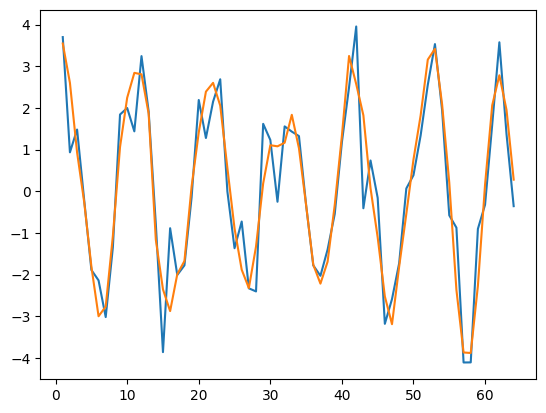

In [26]:
plt.plot(df_1['t'], df_1['Y'])
plt.plot(df_1['t'], itog_1_wma)

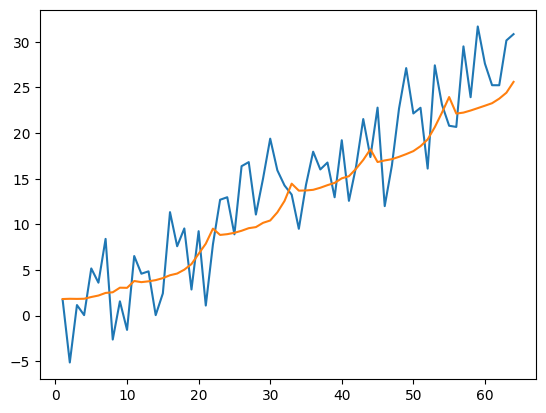

In [27]:
plt.plot(df_2['t'], df_2['Y'])
plt.plot(df_2['t'], itog_2_wma)

In [29]:
print("Для первого ряда", Q(5, np.array(df_1['e'])))
print("Для второго ряда",Q(5, np.array(df_2['e'])))

Для первого ряда Автокорреляция присутствует: 29.65407194975771>11.070497693516351
Для второго ряда Автокорреляция отсутствует: 3.6624099776512544<11.070497693516351


In [30]:
dl = 1.567
du = 1.629
if 0 <= darbin_watson(np.array(df_1['e'])) <= 2:
  print('Для первого файла -','dl =', dl, 'd =', darbin_watson(np.array(df_1['e'])), 'du =', du)
else:
  print('Для первого файла -','dl =', dl, 'd =', 4 - darbin_watson(np.array(df_1['e'])), 'du =', du)

if 0 <= darbin_watson(np.array(df_2['e'])) <= 2:
  print('Для второго файла -','dl =', dl, 'd =', darbin_watson(np.array(df_2['e'])), 'du =', du)
else:
  print('Для второго файла -', 'dl =', dl, 'd =', 4 - darbin_watson(np.array(df_2['e'])), 'du =', du)

Для первого файла - dl = 1.567 d = 1.1450637132770076 du = 1.629
Для второго файла - dl = 1.567 d = 1.4744838043221788 du = 1.629


# EMA

In [31]:
def ema(df, alpha):
  y_new = []
  y_new.append(df[0])
  for i in range(1, len(df)):
    y_new.append(alpha*df[i]+(1-alpha)*y_new[i-1])
  return y_new

In [32]:
ms_1 = []
ms_2 = []
for a in np.arange(0.01, 1, 0.01):
  itog_1_ema = np.array(ema(time_s_1, a))
  itog_2_ema = np.array(ema(time_s_2, a))
  ms_1.append(Q_chet(5, df_1['Y'].values.flatten() - itog_1_ema))
  ms_2.append(Q_chet(5, df_2['Y'].values.flatten() - itog_2_ema))

In [33]:
print("Параметр для первого ряда, при котором Q-статистика минимальна =", np.argmin(ms_1) * 0.01 + 0.01)
print("Параметр для второго ряда, при котором Q-статистика минимальна =", np.argmin(ms_2) * 0.01 + 0.01)

Параметр для первого ряда, при котором Q-статистика минимальна = 0.99
Параметр для второго ряда, при котором Q-статистика минимальна = 0.12


In [34]:
itog_1_ema = np.array(ema(time_s_1, 0.75))
itog_2_ema = np.array(ema(time_s_2, np.argmin(ms_2) * 0.01 + 0.01))

In [35]:
df_1['e'] = df_1['Y'].values - itog_1_ema
df_2['e'] = df_2['Y'].values - itog_2_ema

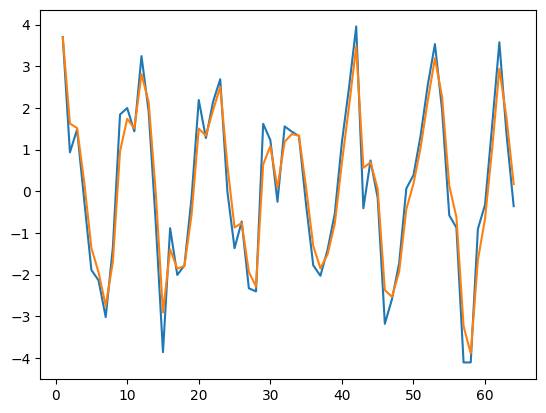

In [36]:
plt.plot(df_1['t'], df_1['Y'])
plt.plot(df_1['t'], itog_1_ema)

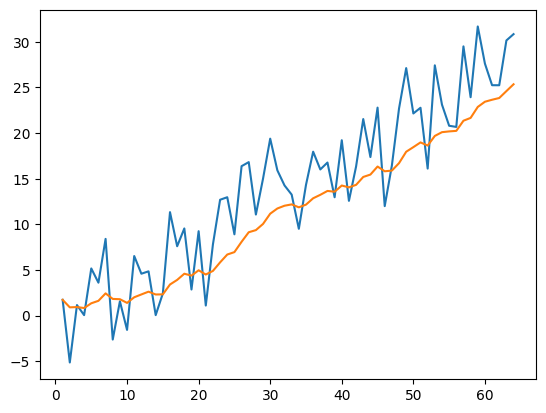

In [37]:
plt.plot(df_2['t'], df_2['Y'])
plt.plot(df_2['t'], itog_2_ema)

In [38]:
print("Для первого ряда", Q(5, np.array(df_1['e'])))
print("Для второго ряда",Q(5, np.array(df_2['e'])))

Для первого ряда Автокорреляция присутствует: 102.83894941684783>11.070497693516351
Для второго ряда Автокорреляция присутствует: 233.76498543690343>11.070497693516351


In [39]:
dl = 1.567
du = 1.629
if 0 <= darbin_watson(np.array(df_1['e'])) <= 2:
  print('Для первого файла -','dl =', dl, 'd =', darbin_watson(np.array(df_1['e'])), 'du =', du)
else:
  print('Для первого файла -','dl =', dl, 'd =', 4 - darbin_watson(np.array(df_1['e'])), 'du =', du)

if 0 <= darbin_watson(np.array(df_2['e'])) <= 2:
  print('Для второго файла -','dl =', dl, 'd =', darbin_watson(np.array(df_2['e'])), 'du =', du)
else:
  print('Для второго файла -', 'dl =', dl, 'd =', 4 - darbin_watson(np.array(df_2['e'])), 'du =', du)

Для первого файла - dl = 1.567 d = 0.18126706532943482 du = 1.629
Для второго файла - dl = 1.567 d = 0.11595603597800266 du = 1.629


# Dema

In [40]:
def dema(df, alpha, gamma):
  y_new = []
  b = []
  y_new.append(df[0])
  b.append(df[1]-df[0])
  for i in range(1, len(df)):
    y_new.append(alpha*df[i]+(1-alpha)*(y_new[i-1])+b[i-1])
    b.append(gamma*(y_new[i]-y_new[i-1])+(1-gamma)*b[i-1])
  return y_new

In [41]:
itog_1_dema = np.array(dema(time_s_1, 0.35, 0.2))
itog_2_dema = np.array(dema(time_s_2, 0.35, 0.3))

In [42]:
min_1 = 10000000
min_2 = 10000000
a_1 = 0
b_1 = 0
a_2 = 0
b_2 = 0
for a in np.arange(0.01, 1, 0.01):
  for b in np.arange(0.01, 1, 0.01):
    itog_1_dema = np.array(dema(time_s_1, a, b))
    itog_2_dema = np.array(dema(time_s_2, a, b))
    q1 = Q_chet(5, df_1['Y'].values.flatten() - itog_1_dema)
    q2 = Q_chet(5, df_2['Y'].values.flatten() - itog_2_dema)
    if q1 > 0:
      if q1 < min_1:
        min_1 = q1
        a_1 = a
        b_1 = b
    if q2 > 0:
      if q2 < min_2:
        min_2 = q2
        a_2 = a
        b_2 = b

In [43]:
print("Параметр для первого ряда, при котором Q-статистика минимальна =", a_1, b_1)
print("Параметр для второго ряда, при котором Q-статистика минимальна =", a_2, b_2)

Параметр для первого ряда, при котором Q-статистика минимальна = 0.63 0.01
Параметр для второго ряда, при котором Q-статистика минимальна = 0.75 0.31


In [44]:
itog_1_dema = np.array(dema(time_s_1, a_1, b_1))
itog_2_dema = np.array(dema(time_s_2, a_2, b_2))

In [45]:
df_1['e'] = df_1['Y'].values - itog_1_dema
df_2['e'] = df_2['Y'].values - itog_2_dema

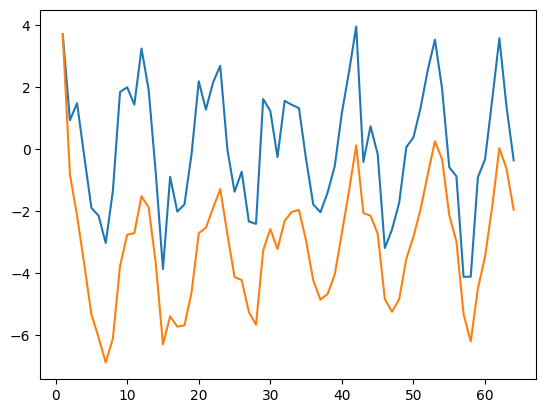

In [46]:
plt.plot(df_1['t'], df_1['Y'])
plt.plot(df_1['t'], itog_1_dema)

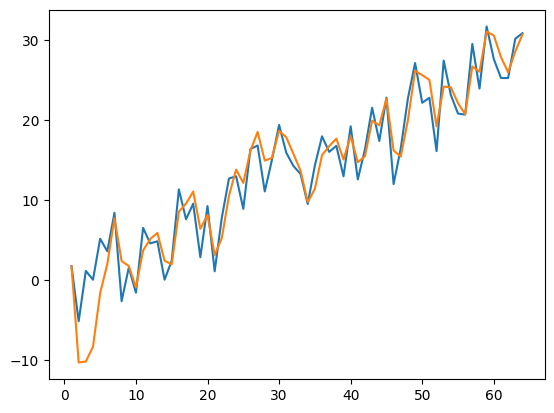

In [47]:
plt.plot(df_2['t'], df_2['Y'])
plt.plot(df_2['t'], itog_2_dema)

In [48]:
print("Для первого ряда", Q(5, np.array(df_1['e'])))
print("Для второго ряда",Q(5, np.array(df_2['e'])))

Для первого ряда Автокорреляция присутствует: 102.83894941684783>11.070497693516351
Для второго ряда Автокорреляция присутствует: 233.76498543690343>11.070497693516351


In [49]:
dl = 1.567
du = 1.629
if 0 <= darbin_watson(np.array(df_1['e'])) <= 2:
  print('Для первого файла -','dl =', dl, 'd =', darbin_watson(np.array(df_1['e'])), 'du =', du)
else:
  print('Для первого файла -','dl =', dl, 'd =', 4 - darbin_watson(np.array(df_1['e'])), 'du =', du)

if 0 <= darbin_watson(np.array(df_2['e'])) <= 2:
  print('Для второго файла -','dl =', dl, 'd =', darbin_watson(np.array(df_2['e'])), 'du =', du)
else:
  print('Для второго файла -', 'dl =', dl, 'd =', 4 - darbin_watson(np.array(df_2['e'])), 'du =', du)

Для первого файла - dl = 1.567 d = 0.18126706532943482 du = 1.629
Для второго файла - dl = 1.567 d = 0.11595603597800266 du = 1.629
